In [7]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../..")
from utils import *
import warnings
warnings.filterwarnings("ignore")
import os
import psutil

pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from catboost import CatBoostClassifier, Pool
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [2]:
''' Data Load '''
train, test = load_data()

''' Seed '''
seed_everything(42)

''' Data Load '''
train = preprocessing(train)
test = preprocessing(test, is_test = True)

---------------- Start MissingValue ----------------


100%|██████████| 26/26 [00:33<00:00,  1.27s/it]


---------------- Start Category ----------------


100%|██████████| 4/4 [03:56<00:00, 59.23s/it]


---------------- Change Dtype ----------------
Memory usage of dataframe is 9602.64 MB
Memory usage after optimization is: 7502.06 MB
Decreased by 21.9%
---------------- Start MissingValue ----------------


100%|██████████| 26/26 [00:05<00:00,  5.19it/s]


---------------- Start Category ----------------


100%|██████████| 4/4 [00:36<00:00,  9.17s/it]


---------------- Change Dtype ----------------
Memory usage of dataframe is 1488.93 MB
Memory usage after optimization is: 1177.29 MB
Decreased by 20.9%


In [3]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [3]:
train = pd.read_csv("/home/workspace/DACON/Click_predict/Model/LGBM_Experiment/train_fre.csv")

In [4]:
''' Train / Vaild Split'''
X_train = train.drop(columns = ["Click"]) 
y_train = train["Click"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [5]:
def objective(trial, t_X, t_y, v_X, v_y):
  param = {"max_depth": trial.suggest_int("max_depth", 20, 40),
           "num_leaves": trial.suggest_int("num_leaves", 2, 350),
           "subsample": trial.suggest_float("subsample", 0.3, 1.0),
           "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
           "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),}

  model = lgb.LGBMClassifier(random_state=42, **param)

  model.fit(t_X, t_y, eval_metric='AUC')
  pred = model.predict_proba(v_X)
  score = roc_auc_score(v_y, pred[:, 1])

  return score

In [8]:
study = optuna.create_study(study_name='LGBMClassifier', direction='maximize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=20)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2024-05-31 15:00:47,645] A new study created in memory with name: LGBMClassifier
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[W 2024-05-31 15:00:55,941] Trial 0 failed with parameters: {'max_depth': 27, 'num_leaves': 333, 'subsample': 0.8123957592679836, 'subsample_freq': 6, 'min_child_samples': 35} because of the following error: LightGBMError('Do not support special JSON characters in feature name.').
Traceback (most recent call last):
  File "/root/anaconda3/envs/code_sim/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1813553/2952337085.py", line 2, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=20)
  File "/tmp/ipykernel_1813553/3359117857.py", line 10, in objective
    model.fit(t_X, t_y, eval_metric='AUC')
  File "/root/anaconda3/envs/code_sim/lib/python3.9/site-packages/lightgbm/sklearn.py", line 

LightGBMError: Do not support special JSON characters in feature name.

: 

In [ ]:
study = optuna.create_study(study_name='LGBMClassifier', direction='maximize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=30)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [27]:
study.best_trial.params

{'max_depth': 30,
 'num_leaves': 306,
 'subsample': 0.9757365622458185,
 'subsample_freq': 8,
 'min_child_samples': 136}

In [28]:
param = study.best_trial.params

In [29]:
param = study.best_trial.params
model = lgb.LGBMClassifier(random_state=42, **param)
model.fit(X_train, y_train, eval_metric='AUC')
pred = model.predict_proba(X_valid)
score = roc_auc_score(y_valid, pred[:, 1])

In [32]:
pred = model.predict_proba(test)

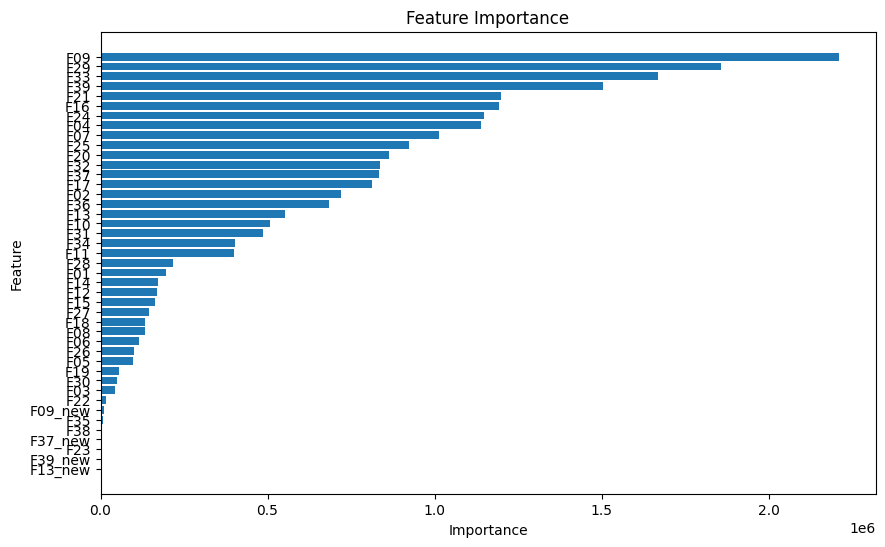

In [39]:
# Feature Importance 추출
importance = model.booster_.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Feature Importance 시각화
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [33]:
''' Submission '''
sample_submission = pd.read_csv('/home/workspace/DACON/Click_predict/data/sample_submission.csv')
sample_submission['Click'] = pred[:, 1]
sample_submission.to_csv('lgbm_HP_Tunning.csv', index=False)

In [4]:
# 실험 2 F01 카테고리(5 under)
''' K-Fold '''
X_train = train.drop(columns=['Click'])
y_train = train['Click']
lgbm = lgb.LGBMClassifier(objective='binary')
pred_list, Score_list, k = Kfold(lgbm, 3, X_train, y_train)

---------------- 1 fold의 Acc: 0.7634894029807717 ----------------
---------------- 2 fold의 Acc: 0.7628595988535454 ----------------
---------------- 3 fold의 Acc: 0.7628177795916435 ----------------
---------------- Aver Acc: 0.7630555938086535 ----------------


In [3]:
# 실험 2 F01 카테고리(100 under)
''' K-Fold '''
X_train = train.drop(columns=['Click'])
y_train = train['Click']
lgbm = lgb.LGBMClassifier(objective='binary')
pred_list, Score_list, k = Kfold(lgbm, 3, X_train, y_train)

---------------- 1 fold의 Acc: 0.7629356434127573 ----------------
---------------- 2 fold의 Acc: 0.7627710371956155 ----------------
---------------- 3 fold의 Acc: 0.7629249862932903 ----------------
---------------- Aver Acc: 0.7628772223005544 ----------------


In [3]:
# 실험 3 여러 카테고리
''' K-Fold '''
X_train = train.drop(columns=['Click'])
y_train = train['Click']
lgbm = lgb.LGBMClassifier(objective='binary')
pred_list, Score_list, k = Kfold(lgbm, 3, X_train, y_train)

---------------- 1 fold의 Acc: 0.7634894029807717 ----------------
---------------- 2 fold의 Acc: 0.7628595988535454 ----------------
---------------- 3 fold의 Acc: 0.7628177795916435 ----------------
---------------- Aver Acc: 0.7630555938086535 ----------------


<Axes: title={'center': 'Top 20 features'}>

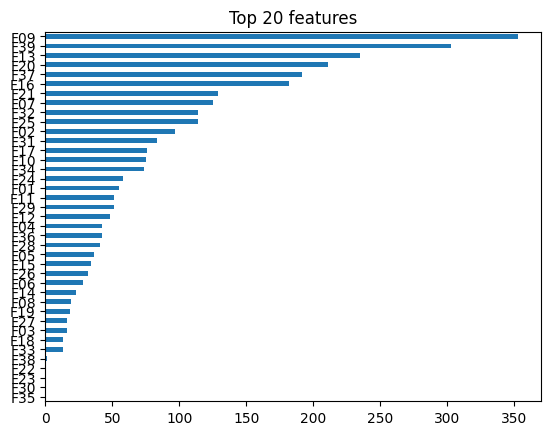

In [5]:
importances = pd.Series(lgbm.feature_importances_, X_train.columns)
import matplotlib.pyplot as plt

n=20
plt.title(f'Top {n} features')
importances.sort_values().plot.barh()

In [4]:
# 실험 LabelEncoder 
cat_col = list(train.select_dtypes(include='category').columns)
for i in cat_col:
    le = LabelEncoder()
    le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for case in np.unique(test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case)
    
    test[i] = le.transform(test[i])

  0%|          | 0/25 [00:06<?, ?it/s]


ValueError: y contains previously unseen labels: 'SRJNHVT'

In [6]:
# 실험 TargetEncoder 
cat_col = list(train.select_dtypes(include='category').columns)
X_train = train.drop(columns=['Click'])
y_train = train['Click']

In [11]:
''' Category encoder '''
for col in cat_col:
    encoder =  TargetEncoder()
    X_train[col] = encoder.fit_transform(X_train[col], y_train)
    test[cat_col] = encoder.transform(test[cat_col])


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
''' Model Fit & K-Fold '''
lgbm = lgb.LGBMClassifier(objective='binary')
pred_list, Score_list, k = Kfold(lgbm, 3, X_train, y_train)

In [ ]:
''' Submission '''
sample_submission = pd.read_csv('/home/workspace/DACON/Click_predict/data/sample_submission.csv')
sample_submission['Click'] = pred
sample_submission.to_csv('lgbm_predict_proba.csv', index=False)